<h1><b>House Prices: Advanced Regression Techniques</b></h1>
<br>Predict sales prices and practice feature engineering, RFs, and gradient boosting
<br>https://www.kaggle.com/c/house-prices-advanced-regression-techniques

<H2>1. Importing packages

In [1]:
library(corrplot)
library(ggplot2)
library(ggpubr)

corrplot 0.84 loaded
Loading required package: magrittr


<H2>2. Definitions

In [2]:
# Evaluation metric function
RMSE <- function(x,y){
    a <- round(sqrt(sum((log(x)-log(y))^2)/length(y)),5)
    return(a)
}

#Convert categorical variable to numeric
categoricalToNumeric <- function(data){
    must.convert <- sapply(data ,is.factor)        #variable needs to be displayed as numeric    
    data.aux<-sapply(data[,must.convert],unclass)  #data.frame of all categorical variables to convert   
    data.out<-cbind(data[,!must.convert],data.aux) #complete data.frame with all variables    
    return(data.out)    
}

<H2>3. Importing data and partition

In [3]:
df.data <- read.csv('../input/train.csv')
df.test <- read.csv('../input/test.csv')

# Set seed so the train/test split
set.seed(42)

df.train.split <- sample(2
                        , nrow(df.data)
                        , replace = TRUE
                        , prob = c(0.8, 0.2))
df.train = df.data[df.train.split == 1,]
df.val   = df.data[df.train.split == 2,]

paste('Length Training Set: ',nrow(df.train),'| Length Validation Set: ',nrow(df.val),'| Length Test Set: ',nrow(df.test))

[1] "Length Training Set:  1175 | Length Validation Set:  285 | Length Test Set:  1459"

<H2>4. Explore data

In [4]:
summary(df.train)
head(df.train)

       Id           MSSubClass        MSZoning    LotFrontage    
 Min.   :   3.0   Min.   : 20.00   C (all):  6   Min.   : 21.00  
 1st Qu.: 368.0   1st Qu.: 20.00   FV     : 58   1st Qu.: 59.00  
 Median : 729.0   Median : 50.00   RH     : 12   Median : 70.00  
 Mean   : 733.3   Mean   : 56.43   RL     :929   Mean   : 70.08  
 3rd Qu.:1099.0   3rd Qu.: 70.00   RM     :170   3rd Qu.: 80.00  
 Max.   :1460.0   Max.   :190.00                 Max.   :313.00  
                                                 NA's   :207     
    LotArea        Street      Alley      LotShape  LandContour  Utilities   
 Min.   :  1300   Grvl:   5   Grvl:  40   IR1:383   Bnk:  51    AllPub:1174  
 1st Qu.:  7654   Pave:1170   Pave:  35   IR2: 33   HLS:  40    NoSeWa:   1  
 Median :  9520               NA's:1100   IR3: 10   Low:  30                 
 Mean   : 10624                           Reg:749   Lvl:1054                 
 3rd Qu.: 11645                                                              
 Max

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
3,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,9,2008,WD,Normal,223500
5,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,7,20,RL,75,10084,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,8,2007,WD,Normal,307000
8,8,60,RL,NA,10382,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,Shed,350,11,2009,WD,Normal,200000
9,9,50,RM,51,6120,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,4,2008,WD,Abnorml,129900


<H2>5. Data prep

In [5]:
#Encode character features as numeric
df.train <- categoricalToNumeric(df.train)
df.val <- categoricalToNumeric(df.val)
df.test <- categoricalToNumeric(df.test)

head(df.train)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,⋯,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
3,3,60,68,11250,7,5,2001,2002,162,486,⋯,2,2,5,5,3,NA,NA,NA,9,5
5,5,60,84,14260,8,5,2000,2000,350,655,⋯,2,2,5,5,3,NA,NA,NA,9,5
6,6,50,85,14115,5,5,1993,1995,0,732,⋯,2,3,5,5,3,NA,3,3,9,5
7,7,20,75,10084,8,5,2004,2005,186,1369,⋯,2,2,5,5,3,NA,NA,NA,9,5
8,8,60,NA,10382,7,6,1973,1973,240,859,⋯,2,2,5,5,3,NA,NA,3,9,5
9,9,50,51,6120,7,5,1931,1950,0,0,⋯,6,3,2,5,3,NA,NA,NA,9,1


In [6]:
#Set NA's to 0
df.train[is.na(df.train)] <- 0
df.val[is.na(df.val)] <- 0
df.test[is.na(df.test)] <- 0

head(df.train)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,⋯,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
3,3,60,68,11250,7,5,2001,2002,162,486,⋯,2,2,5,5,3,0,0,0,9,5
5,5,60,84,14260,8,5,2000,2000,350,655,⋯,2,2,5,5,3,0,0,0,9,5
6,6,50,85,14115,5,5,1993,1995,0,732,⋯,2,3,5,5,3,0,3,3,9,5
7,7,20,75,10084,8,5,2004,2005,186,1369,⋯,2,2,5,5,3,0,0,0,9,5
8,8,60,0,10382,7,6,1973,1973,240,859,⋯,2,2,5,5,3,0,0,3,9,5
9,9,50,51,6120,7,5,1931,1950,0,0,⋯,6,3,2,5,3,0,0,0,9,1


<H2>6. Model fit and Predict</H2>
Fit on significant features

In [7]:
#Formula(remove Id)
col.names <- colnames(df.train)
col.names <- col.names[col.names != c('Id','SalePrice')]
fmla <- as.formula(paste("SalePrice ~ ", paste(col.names, collapse= "+")))

#Model
model = lm(formula = fmla, data = df.train)
model.predict <- predict(model,df.val)

Warning message in col.names != c("Id", "SalePrice"):
“longer object length is not a multiple of shorter object length”Warning message in predict.lm(model, df.val):
“prediction from a rank-deficient fit may be misleading”

<H2>7. RMSE (root mean squared error)

In [8]:
rmse <- RMSE(df.val$SalePrice, model.predict)
paste('RMSE: ',rmse)

[1] "RMSE:  0.15046"

<H3>7.1 Predict vs Actual

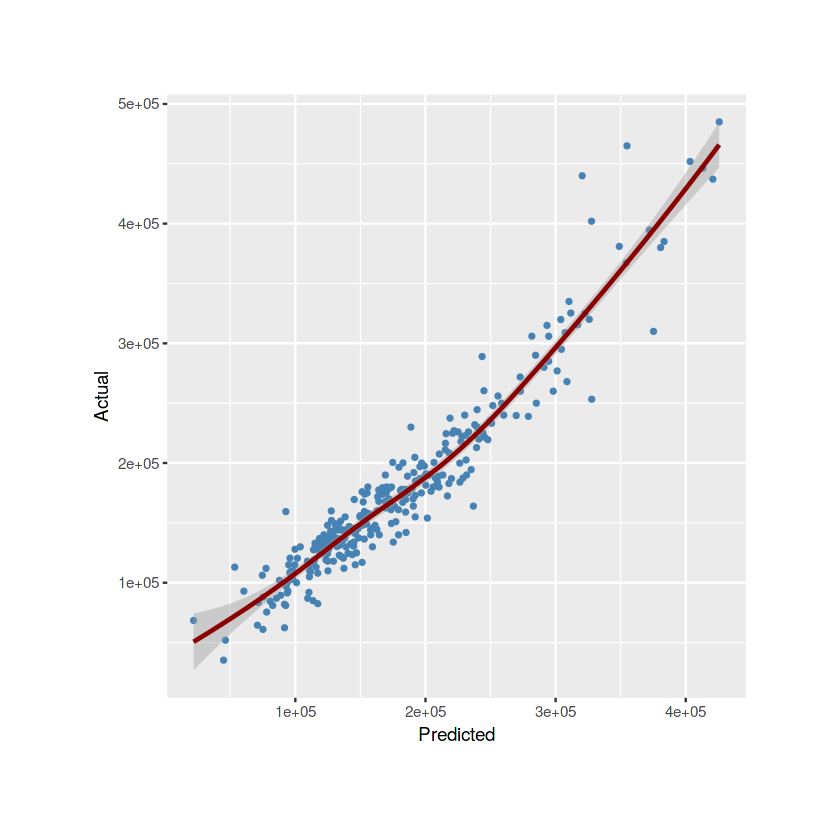

In [9]:
ggplot(df.val,aes(x=model.predict,y=SalePrice))+
  geom_point(size=1 , color = "steelblue")+
  geom_smooth(method = "loess", color="darkred")+
  labs(x="Predicted", y="Actual")+
  theme(plot.margin = unit(c(2,2,2,2), "cm"))

<H2>8. Create submission file

In [10]:
predict.Test <- predict(model,df.test)
df.predict.Test <- df.test[1]
df.predict.Test$SalePrice <- predict.Test

head(df.predict.Test)

write.csv(df.predict.Test, file = 'submission.csv', row.names=FALSE)

Warning message in predict.lm(model, df.test):
“prediction from a rank-deficient fit may be misleading”

Id,SalePrice
1461,112772.2
1462,153308.1
1463,166980.1
1464,187903.1
1465,189939.2
1466,171617.3
